In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import sys

## Define some paths and load files

In [26]:
# Results from simple setup-1
original_label_path = "/Users/kiyoshi/Desktop/msdn_results/0819/msd_369_novel_44_weighted_loss_setup1/test_results_0818/original_labels.npy"
target_label_path = "/Users/kiyoshi/Desktop/msdn_results/0819/msd_369_novel_44_weighted_loss_setup1/test_results_0818/targets.npy"
prob_path = "/Users/kiyoshi/Desktop/msdn_results/0819/msd_369_novel_44_weighted_loss_setup1/test_results_0818/probs.npy"
rt_path = "/Users/kiyoshi/Desktop/msdn_results/0819/msd_369_novel_44_weighted_loss_setup1/test_results_0818/rts.npy"

In [3]:
# Results from simple setup-2
original_label_path = "/Users/kiyoshi/Desktop/msdn_results/0819/msd_369_novel_44_weighted_loss_setup2/test_results_0818/original_labels.npy"
target_label_path = "/Users/kiyoshi/Desktop/msdn_results/0819/msd_369_novel_44_weighted_loss_setup2/test_results_0818/targets.npy"
prob_path = "/Users/kiyoshi/Desktop/msdn_results/0819/msd_369_novel_44_weighted_loss_setup2/test_results_0818/probs.npy"
rt_path = "/Users/kiyoshi/Desktop/msdn_results/0819/msd_369_novel_44_weighted_loss_setup2/test_results_0818/rts.npy"

In [27]:
original_labels = np.load(original_label_path)
target_labels = np.load(target_label_path)
probs = np.load(prob_path)
rts = np.load(rt_path)

In [28]:
print("There are %d test samples." % len(target_labels))

There are 43850 test samples.


## Get stats from the network output

In [29]:
def get_exit_stats(original_labels,
                   target_labels,
                   probs,
                   rts,
                   top_1_threshold,
                   top_3_threshold=0.05,
                   top_5_threshold=0.03,
                   top_k=5,
                   nb_clfs=5,
                   nb_training_classes=369):
    """
    
    
    """
    
    known_exit = []
    known_rts = []
    
    unknown_exit = []
    unknown_rts = []
    
    predictions = []
    
    
    for i in range(len(original_labels)):
#     for i in range(3):
        # Get eveything we need for a test sample first
        original_label = original_labels[i]
        target_label = target_labels[i]
        prob = probs[i]
        rt = rts[i]
        
        # check each classifier in order and decide when to exit
        for j in range(nb_clfs):
            one_prob = prob[j]
            pred = np.argmax(one_prob)
            max_prob = np.sort(one_prob)[-1]
            
            # If this is not the last classifier 
            if j != nb_clfs-1:
                # Only consider top-1 if it is not the last classifier
                if max_prob > top_1_threshold:
                    predictions.append(pred)
                    
                    if original_label < nb_training_classes-1:
                        known_exit.append(j)
                        known_rts.append(rt[j])
                    elif original_label >= nb_training_classes-1:
                        unknown_exit.append(j)
                        unknown_rts.append(rt[j])
                    
                    # If top-1 is larger than threshold,
                    # then directly go to next sample
                    break
                    
                else:
                    continue
             
            # If this is the last classifier
            else:
                # TODO: May need to update to top-k, but do top-1 first
                # Get the top-k in decreasing order
                #index = np.argpartition(prob, -top_k)[-top_k:]
                #ind_top_k = np.flipud(index[np.argsort(prob[index])])
                
                
                # Only consider top-1 now...
                if max_prob > top_1_threshold:
                    predictions.append(pred)
                   
                # If the probability is smaller than threshold for the last classifier,
                # reject the sample as unknow
                else:
                    predictions.append(-1)
                    
                if original_label < nb_training_classes-1:
                    known_exit.append(j)
                    known_rts.append(rt[j])
                else:
                    unknown_exit.append(j)
                    unknown_rts.append(rt[j])
                    
    return known_exit, known_rts, unknown_exit, unknown_rts, predictions
        
    
    

In [30]:
def get_threshold_curve(thresholds):
    
    known_acc_list, unknown_acc_list = [], []
    
    for thresh in thresholds:
        known_exit, known_rts, unknown_exit, unknown_rts, predictions = get_exit_stats(original_labels=original_labels,
                                                                                target_labels=target_labels,
                                                                                probs=probs,
                                                                                rts=rts,
                                                                               top_1_threshold=thresh)

        
        known_known, known_unknown, unknown_known, unknown_unknown = 0, 0, 0, 0
        known_pred = predictions[:len(known_exit)]
        known_target = target_labels[:len(known_exit)]
        unknown_pred = predictions[len(known_exit):]
        unknown_target = target_labels[len(known_exit):]
        
        
        for i in range(len(known_pred)):
            if known_pred[i] != -1:
                known_known += 1
            else:
                known_unknown += 1
        
        for i in range(len(unknown_pred)):
            if unknown_pred[i] != -1:
                unknown_known += 1
            else:
                unknown_unknown += 1
                
        print(known_known, known_unknown, unknown_known, unknown_unknown)
                
        known_acc = known_known/(known_known+known_unknown)
        unknown_acc = unknown_unknown/(unknown_known+unknown_unknown)

        known_acc_list.append(known_acc)
        unknown_acc_list.append(unknown_acc) 
    
    return known_acc_list, unknown_acc_list

In [31]:
threshold_list = np.linspace(0.7, 0.9, 11)

In [32]:
known_accs, unknown_accs = get_threshold_curve(thresholds=threshold_list)

38537 813 4186 314
38384 966 4138 362
38200 1150 4086 414
38006 1344 4026 474
37803 1547 3949 551
37578 1772 3858 642
37293 2057 3785 715
36968 2382 3689 811
36599 2751 3595 905
36144 3206 3463 1037
35637 3713 3317 1183


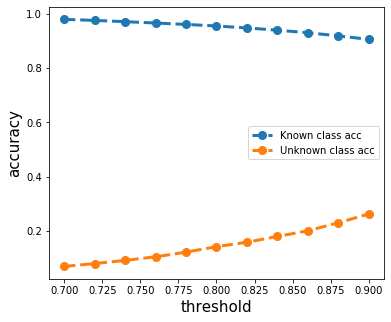

In [33]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlabel('threshold', fontsize=15)
ax.set_ylabel('accuracy', fontsize=15)

ax.plot(threshold_list, 
        known_accs,  
        label='Known class acc', 
        marker='o', 
        linestyle='dashed',
        linewidth=3, 
        markersize=8)
ax.plot(threshold_list, 
        unknown_accs, 
        label="Unknown class acc",
        marker='o', 
        linestyle='dashed',
        linewidth=3, 
        markersize=8)
ax.legend()
plt.show()

## Count where the samples exit

In [34]:
import matplotlib.pyplot as plt

In [35]:
known_exit, known_rts, unknown_exit, unknown_rts, predictions = get_exit_stats(original_labels=original_labels,
                                                                                target_labels=target_labels,
                                                                                probs=probs,
                                                                                rts=rts,
                                                                               top_1_threshold=0.90)

In [36]:
known_exit_count = np.unique(np.array(known_exit), return_counts=True)

In [37]:
known_exit_count[1]

array([30728,  3467,  1055,   272,  3828])

<BarContainer object of 5 artists>

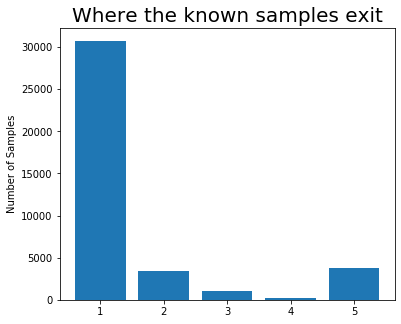

In [38]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel('Number of Samples', fontsize=10)
ax.set_title('Where the known samples exit', fontsize=20)

ax.bar(known_exit_count[0]+1, height=known_exit_count[1])

In [39]:
unknown_exit_count = np.unique(np.array(unknown_exit), return_counts=True)

<BarContainer object of 5 artists>

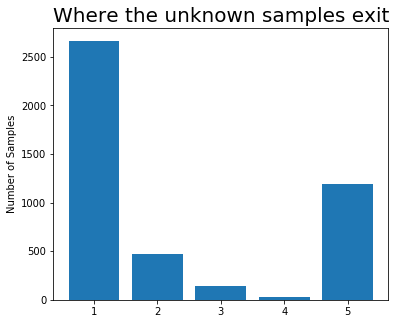

In [40]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel('Number of Samples', fontsize=10)
ax.set_title('Where the unknown samples exit', fontsize=20)

ax.bar(unknown_exit_count[0]+1, height=unknown_exit_count[1])

## Count the CM for known and unknown

In [41]:
known_accs, unknown_accs = get_threshold_curve(thresholds=[0.9])

35637 3713 3317 1183


In [42]:
print(known_accs, unknown_accs)

[0.9056416772554002] [0.2628888888888889]


In [43]:
known_rts_clf5 = rts[:len(known_exit), 4]
unknown_rts_clf = rts[len(known_exit):, 4]

In [44]:
print(np.median(known_rts_clf5),np.median(unknown_rts_clf))

0.02931975293904543 0.03172642318531871


In [45]:
print(np.mean(known_rts_clf5),np.mean(unknown_rts_clf))

0.030699893621895864 0.03267030275933858


In [46]:
print(np.median(known_rts),np.median(unknown_rts))

0.009946127887815237 0.01151929353363812


In [47]:
print(np.mean(known_rts),np.mean(unknown_rts))

0.013426438220474854 0.01816980642101003
